In [44]:
import os
import sys
module_path = os.path.abspath(os.path.join('fede'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import pandas as pd
from client import Client
from supported_modles import Supported_modles
import utils
from fedavg import Fedavg
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import random
from copy import deepcopy
import statistics
import matplotlib.pyplot as plt

In [45]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [46]:
selected_model = Supported_modles.NN_classifier

In [47]:
clients, test_x, test_y = utils.set_data(selected_model, True, False, True)

Creating node1.
Creating node2.
Creating node3.
Creating node4.
Creating node5.


In [48]:
f1_before = []
for client in clients:
    client.init_empty_model(epochs=50)
    try:
        client.train_model(epochs=50)
    except ValueError:
        score = 0
        print(client.name)
        f1_before.append(score)
        continue 
    try: 
        score = client.test_model_f1(y_test=test_y, X_test=test_x)
    except IndexError:
        score = 0
    f1_before.append(score)
    print(score)

0.971075112061801
0.9716662121625306
0.9720056697377745
0.9723099542583316
0.966678882147753


In [49]:
fedavg = Fedavg("global", selected_model)

[Errno 98] Address already in use
Waitiing for a Connection..


In [50]:
#clients.remove(clients[3])

In [51]:
###First learn model on clients:
def plot(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        round_scores = []
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
        round_scores.append(score)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            round_scores.append(score)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(round_scores)

    #print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('CICIDS - ANN, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


In [52]:
###First learn model on clients:
def find_scores(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(score)

    print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    # plt.xlabel("Number of Rounds", fontsize=16)
    # plt.ylabel("F1-Score", fontsize=16)
    # plt.xticks(range(0,rounds+1,5))
    # plt.xticks(size = 16)
    # plt.yticks(size = 16)
    # plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    # plt.show()


In [53]:
plot(10,0.9,19)

0.984771711518346
--------------------
0.9860988195569594
--------------------
0.9869165487977369
--------------------
0.9826223465975019
--------------------
0.9829958410036136
--------------------
0.9838038450517813
--------------------
0.98087539700931
--------------------
0.9814040298080461
--------------------
0.9843503776558169
--------------------
0.9815954260822215
--------------------


TypeError: can't convert type 'list' to numerator/denominator

0.8150115289814742
--------------------
0.8133007738170748
--------------------
0.80734326068895
--------------------
0.8115841224173634
--------------------
0.8155333640274978
--------------------
0.8099107964826514
--------------------
0.8131327557205877
--------------------
0.7828703208760328
--------------------
0.7944754058638236
--------------------
0.8020621527722186
--------------------


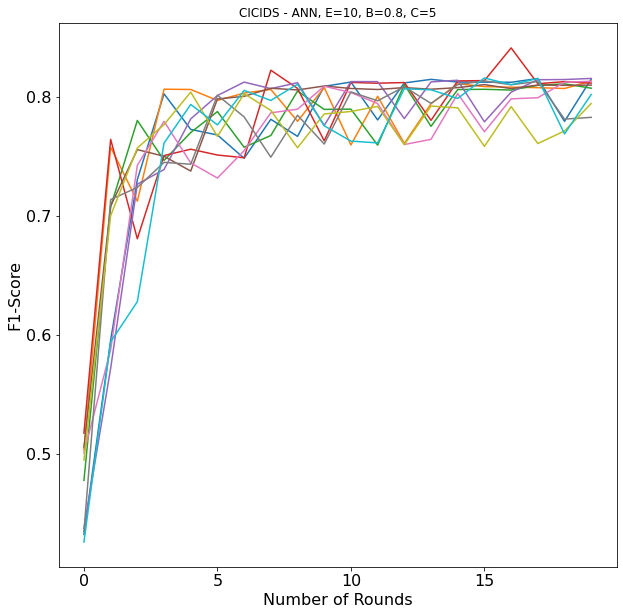

In [ ]:
plot(10,0.8,19)

0.8083041930504363
--------------------
0.8080098887515451
--------------------
0.8059520967613593
--------------------
0.7403089754525637
--------------------
0.7765430039873256
--------------------
0.8116355792412131
--------------------
0.8110056623335193
--------------------
0.7709417313251179
--------------------
0.8118893672454603
--------------------
0.6529424700170847
--------------------


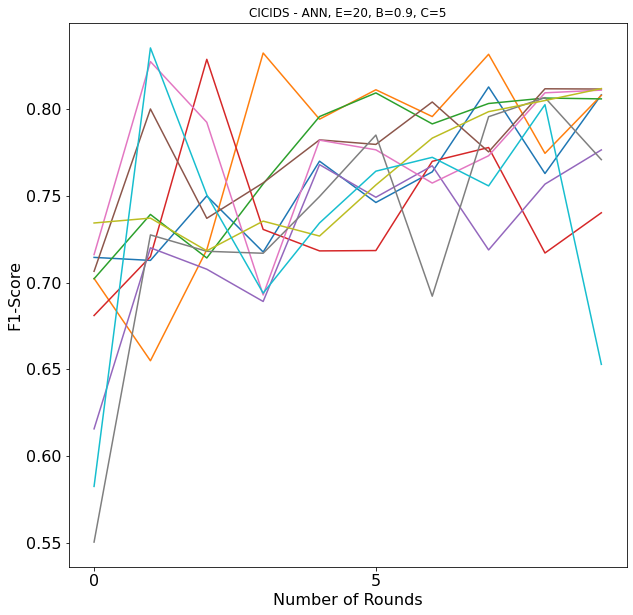

In [ ]:
plot(20,0.9,9)

0.7660461144321093
--------------------
0.8424613103512186
--------------------
0.7764448981906868
--------------------
0.7940320232896653
--------------------
0.793250569403009
--------------------
0.8032289291046613
--------------------
0.7659038278163738
--------------------
0.7927191893530413
--------------------
0.8821209465381245
--------------------
0.7925834843385969
--------------------


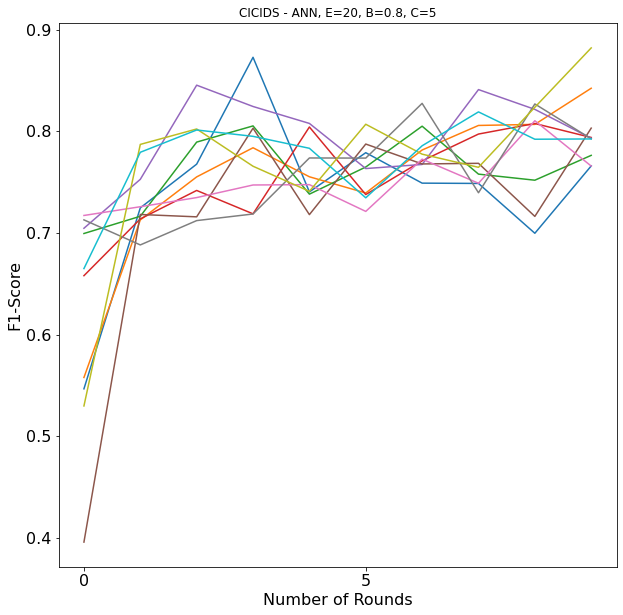

In [ ]:
plot(20,0.8,9)

0.7522970851252646 0.7353068047018225 0.8351084484384534 0.7680690042631945 0.8038763415024828 0.8327698021173993 0.7438557597381229 0.7486315057780866 0.7751652530862334 0.7718966035467387 0.7718966035467387
--------------------
0.678203201906637 0.6989065366075619 0.8252516842025586 0.7592560200571395 0.7614175881397984 0.7453708546919133 0.7828347260317662 0.7574428516079039 0.7956143179619478 0.8119714964370546 0.8119714964370546
--------------------
0.7041109939887753 0.7481296130971091 0.7795173904842055 0.594223294464549 0.739150128336325 0.790102278612118 0.7893833953714192 0.7862535464119127 0.7547547239490368 0.7892289810151105 0.7892289810151105
--------------------
0.7149618536309693 0.74816428396255 0.7386716115981118 0.7239684616200545 0.739209916952487 0.7826487820836926 0.789751905302416 0.7580502764741415 0.7919810862454253 0.7902194964493222 0.7902194964493222
--------------------
0.7074747113060603 0.7371843033000058 0.7503990999346236 0.767696840951141 0.82545768837

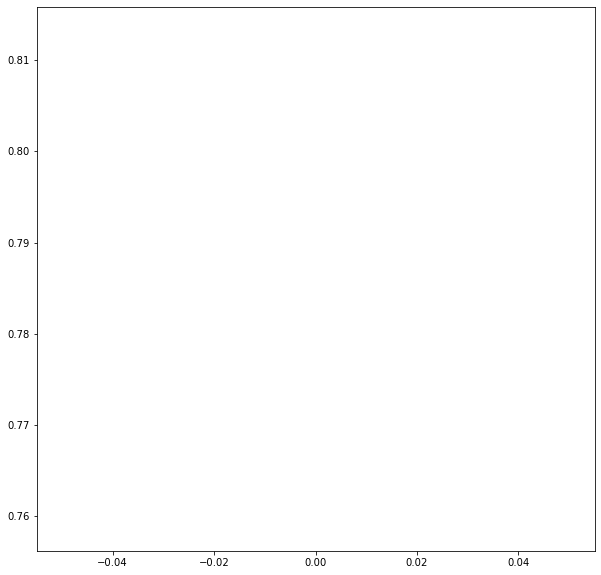

In [43]:
find_scores(10, 0.9, 10)